In [1]:
import pandas as pd
import numpy as np
import sklearn
import gensim

#Vectorizers (Word embeddings for doc-term matrix)
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

#Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD #LSA
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim import corpora, models, similarities, matutils #LDA

#Clustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
# !conda install -c districtdatalabs yellowbrick
from yellowbrick.cluster import KElbowVisualizer


#Pipeline
from sklearn.pipeline import Pipeline

#Bayes Optimization Parameter Tuner
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

#Visualization
import matplotlib.pyplot as plt

# adjectives = []
# for sent in hp.sents:
#     for word in sent:
#         if 'Harry' in word.string:
#             for child in word.children:
#                 if child.pos_ == 'ADJ': adjectives.append(child.string.strip()) #part of speech         
# Counter(adjectives).most_common(10)


# Import Data

In [2]:
full_df = pd.read_pickle('full_df_preprocessed.pkl')

In [3]:
positive_df = full_df[full_df['sentiment']=='positive']
negative_df = full_df[full_df['sentiment']=='negative']
neutral_df = full_df[full_df['sentiment']=='neutral']

# Pipeline of Vectorization, Dimensionality Reduction, and Clustering Methods

In [4]:
full_df['movie'].value_counts()

lionking          20791
aladdin           19293
beautyandbeast     4571
junglebook         3982
cinderella         2875
Name: movie, dtype: int64

In [5]:
corpus = [items[1] for items in full_df['review_processed'].iteritems()]
Pipeline_TFIDF_NMF = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])),
                ('NMF', NMF(n_components=5,random_state=10))])
TFIDF_NMF = Pipeline_TFIDF_NMF.fit_transform(corpus)
TFIDF_NMF.shape

(51512, 5)

In [6]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """Function to display topics from Vectorizer after performing Vectorization and Dimensionality Reduction"""
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [7]:
tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie', 'film'])
doc_word_tfidfvec = tfidfvec.fit_transform(corpus)
print(doc_word_tfidfvec.shape)
tfidfvec.get_feature_names()
NMF_dimreduc = NMF(n_components=5,random_state=10)
tfidfvec_NMF = NMF_dimreduc.fit_transform(doc_word_tfidfvec) 
display_topics(NMF_dimreduc, tfidfvec.get_feature_names(), 10)

#Normalize before for clustering to get an approximate cosine similarity distance (instead of kmeans default of euclidean distance, which is sensitive to document/review length)
normalized_doc_topic_nmf_tfidf = sklearn.preprocessing.normalize(TFIDF_NMF)

(51512, 58)

Topic  0
not, with, like, disney, make, feel, watch, story, character, well

Topic  1
love, amaze, kid, smith, beautiful, old, music, song, story, genie

Topic  2
great, smith, genie, job, loved, music, cast, amaze, fun, story

Topic  3
good, smith, genie, job, enjoy, think, music, act, story, fun

Topic  4
original, well, loved, remake, like, new, story, song, amaze, version


In [8]:
def display_cluster(X,km=[],num_clusters=0):
    """Function to display k-means clusters into 2-dimensional space"""
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

Elbow Method Plot (inertia vs. number of clusters)

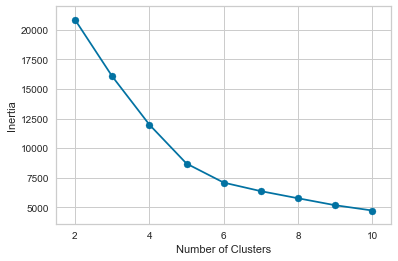

In [9]:
list_num_clusters = list(range(2,11))

inertia = []

for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=10, init='k-means++')
    km.fit_predict(normalized_doc_topic_nmf_tfidf)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');


#center: 4 docs closest --> cosine similarity

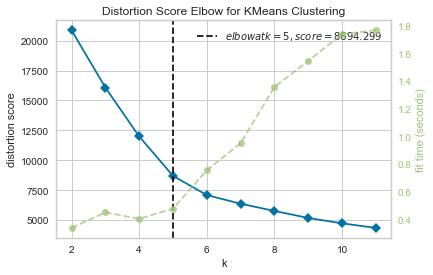

In [10]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(normalized_doc_topic_nmf_tfidf)        # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
elbow_full = visualizer.elbow_value_

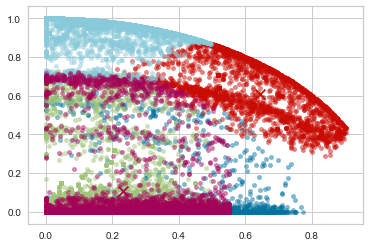

In [11]:
display_cluster(normalized_doc_topic_nmf_tfidf, km, elbow_full)

In [12]:

km = KMeans(n_clusters=elbow_full, random_state=10, init='k-means++')
km.fit_predict(normalized_doc_topic_nmf_tfidf)
full_df['cluster'] = km.labels_

In [13]:
full_df

,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
0,"Disney, WHAT. HAVE. YOU. DONE Just to be clea...",lionking,imdb,1,negative,"[disney, clear, time, favorite, movie, not, st...",disney clear time favorite movie not stress en...,1
1,No soul. The original Lion King is one of my ...,lionking,imdb,1,negative,"[no, soul, original, lion, king, favorite, mov...",no soul original lion king favorite movie time...,3
5,Seriously? So anyone else notice it has a hig...,lionking,imdb,1,negative,"[seriously, notice, high, score, 7.5, rating, ...",seriously notice high score 7.5 rating not str...,1
6,Overrated and way too much spotlight on beyon...,lionking,imdb,1,negative,"[overrated, way, spotlight, beyonce, lion, kin...",overrated way spotlight beyonce lion king only...,1
8,Terrible acting!! Doesn't compare to the orig...,lionking,imdb,1,negative,"[terrible, act, not, compare, original, love, ...",terrible act not compare original love origina...,1
...,...,...,...,...,...,...,...,...
3040,A magically wonderful film filled with adventu...,cinderella,rottentomatoes,5,positive,"[magically, wonderful, film, fill, with, adven...",magically wonderful film fill with adventure f...,1
3041,Disney has overdid the faithfulness of their o...,cinderella,rottentomatoes,4,positive,"[disney, overdo, faithfulness, animate, classi...",disney overdo faithfulness animate classic pro...,1
3042,Magic....that's about right. A re-tell of the ...,cinderella,rottentomatoes,4,positive,"[magic, ...., right, tell, original, disney, m...",magic .... right tell original disney movie wi...,3
3043,A good movie that sets it apart from the origi...,cinderella,rottentomatoes,4,positive,"[good, movie, set, apart, original, story, cin...",good movie set apart original story cinderella...,4


In [14]:
full_df['cluster'].value_counts()

1    16509
3    10495
0     9660
2     9195
4     5653
Name: cluster, dtype: int64

In [15]:
corpus = [items[1] for items in full_df['review_processed'].iteritems()]

tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie', 'film'])
doc_word_tfidfvec = tfidfvec.fit_transform(corpus)
print(doc_word_tfidfvec.shape)
tfidfvec.get_feature_names()
NMF_dimreduc = NMF(n_components=5,random_state=10)
tfidfvec_NMF = NMF_dimreduc.fit_transform(doc_word_tfidfvec) 
print(tfidfvec_NMF.shape)
display_topics(NMF_dimreduc, tfidfvec.get_feature_names(), 10)

(51512, 58)
(51512, 5)

Topic  0
not, with, like, disney, make, feel, watch, story, character, well

Topic  1
love, amaze, kid, smith, beautiful, old, music, song, story, genie

Topic  2
great, smith, genie, job, loved, music, cast, amaze, fun, story

Topic  3
good, smith, genie, job, enjoy, think, music, act, story, fun

Topic  4
original, well, loved, remake, like, new, story, song, amaze, version


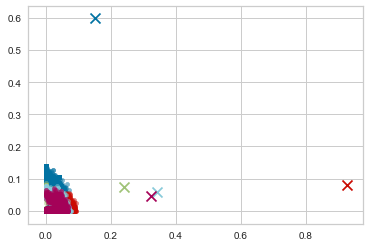

In [16]:
display_cluster(tfidfvec_NMF, km, elbow_full)

# Positive Reviews

In [18]:
positive_df = full_df[full_df['sentiment']=='positive']


positive_corpus = [items[1] for items in positive_df['review_processed'].iteritems()]
Pipeline_TFIDF_NMF = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])),
                ('NMF', NMF(n_components=5,random_state=10))])
TFIDF_NMF_positive = Pipeline_TFIDF_NMF.fit_transform(positive_corpus)

In [19]:
normalized_doc_topic_nmf_tfidf_pos = sklearn.preprocessing.normalize(TFIDF_NMF_positive)

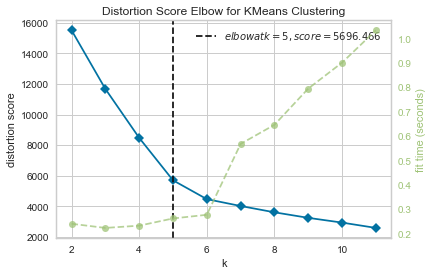

In [20]:
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(normalized_doc_topic_nmf_tfidf_pos)        # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
elbow_pos = visualizer.elbow_value_

In [21]:
km = KMeans(n_clusters=elbow_pos, random_state=10, init='k-means++')
km.fit_predict(normalized_doc_topic_nmf_tfidf_pos)
positive_df['cluster'] = km.labels_
positive_df

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
260,Wonderful Animal Movie 2019 Rating 9.1/10This...,lionking,imdb,9,positive,"[wonderful, animal, movie, 2019, rating, 9.1/1...",wonderful animal movie 2019 rating 9.1/10this ...,2
381,Don't listen to the Critics!!! This movie is ...,lionking,imdb,10,positive,"[not, listen, critics, movie, amazing, imagery...",not listen critics movie amazing imagery color...,0
469,Great movie The lion king is propably the bes...,lionking,imdb,7,positive,"[great, movie, lion, king, propably, well, liv...",great movie lion king propably well live actio...,2
470,Best remake for sure! Don't listen to any cri...,lionking,imdb,10,positive,"[best, remake, sure, not, listen, critic, peop...",best remake sure not listen critic people like...,3
486,Timon and Pumba save the world If I'm being h...,lionking,imdb,7,positive,"[timon, pumba, save, world, honest, well, timo...",timon pumba save world honest well timon pumba...,1
...,...,...,...,...,...,...,...,...
3040,A magically wonderful film filled with adventu...,cinderella,rottentomatoes,5,positive,"[magically, wonderful, film, fill, with, adven...",magically wonderful film fill with adventure f...,0
3041,Disney has overdid the faithfulness of their o...,cinderella,rottentomatoes,4,positive,"[disney, overdo, faithfulness, animate, classi...",disney overdo faithfulness animate classic pro...,0
3042,Magic....that's about right. A re-tell of the ...,cinderella,rottentomatoes,4,positive,"[magic, ...., right, tell, original, disney, m...",magic .... right tell original disney movie wi...,1
3043,A good movie that sets it apart from the origi...,cinderella,rottentomatoes,4,positive,"[good, movie, set, apart, original, story, cin...",good movie set apart original story cinderella...,1


In [22]:
positive_df['cluster'].value_counts()

0    13141
3     6994
1     6176
2     6173
4     6172
Name: cluster, dtype: int64

In [23]:
positive_df[positive_df['cluster']==1]

,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
486,Timon and Pumba save the world If I'm being h...,lionking,imdb,7,positive,"[timon, pumba, save, world, honest, well, timo...",timon pumba save world honest well timon pumba...,1
500,Remind me of the old times If I hadn't watche...,lionking,imdb,9,positive,"[remind, old, time, not, watch, original, movi...",remind old time not watch original movie easil...,1
615,Nostalgic So much emotions and sensations whe...,lionking,imdb,10,positive,"[nostalgic, emotion, sensation, movie, childho...",nostalgic emotion sensation movie childhood un...,1
617,Great movie BUT.. I felt that I'm watching so...,lionking,imdb,10,positive,"[great, movie, .., feel, watch, good, graphic]",great movie .. feel watch good graphic,1
629,It Was Awesome! You guys need to watch it. Re...,lionking,imdb,10,positive,"[awesome, guy, need, watch, good, lil, improve...",awesome guy need watch good lil improve not ma...,1
...,...,...,...,...,...,...,...,...
3025,"Gorgeous costumes, beautiful performances. Ken...",cinderella,rottentomatoes,5,positive,"[gorgeous, costume, beautiful, performance, ke...",gorgeous costume beautiful performance kenneth...,1
3028,A really good adaption that doesn't go dark an...,cinderella,rottentomatoes,4,positive,"[good, adaption, not, go, dark, gritty, old, f...",good adaption not go dark gritty old fashion s...,1
3029,A great live-action Disney take on Cinderella ...,cinderella,rottentomatoes,4,positive,"[great, live, action, disney, cinderella, make...",great live action disney cinderella make good ...,1
3042,Magic....that's about right. A re-tell of the ...,cinderella,rottentomatoes,4,positive,"[magic, ...., right, tell, original, disney, m...",magic .... right tell original disney movie wi...,1


In [24]:
tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])
doc_word_tfidfvec_positive = tfidfvec.fit_transform(positive_corpus)
print(doc_word_tfidfvec_positive.shape)
tfidfvec.get_feature_names()
NMF_dimreduc = NMF(n_components=3,random_state=10)
tfidfvec_NMF_positive = NMF_dimreduc.fit_transform(doc_word_tfidfvec_positive) 
print(tfidfvec_NMF_positive.shape)
display_topics(NMF_dimreduc, tfidfvec.get_feature_names(), 10)


(38656, 47)
(38656, 3)

Topic  0
not, good, original, with, like, well, disney, make, story, watch

Topic  1
love, absolutely, amaze, kid, smith, family, awesome, beautiful, music, song

Topic  2
great, smith, job, genie, loved, music, family, cast, awesome, fun


# Negative Reviews

In [25]:
negative_df = full_df[full_df['sentiment']=='negative']

negative_corpus = [items[1] for items in negative_df['review_processed'].iteritems()]
Pipeline_TFIDF_NMF = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])),
                ('NMF', NMF(n_components=3,random_state=10))])
TFIDF_NMF_negative = Pipeline_TFIDF_NMF.fit_transform(negative_corpus)



In [26]:
normalized_doc_topic_nmf_tfidf_neg = sklearn.preprocessing.normalize(TFIDF_NMF_negative)

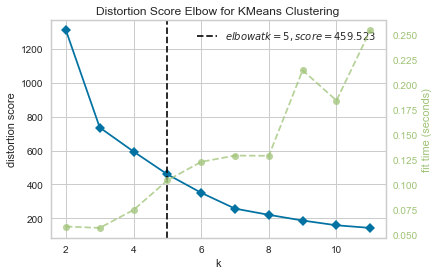

In [27]:
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(normalized_doc_topic_nmf_tfidf_neg)        # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
elbow_neg = visualizer.elbow_value_

In [28]:
km = KMeans(n_clusters=elbow_neg, random_state=10, init='k-means++')
km.fit_predict(sklearn.preprocessing.normalize(TFIDF_NMF_negative))
negative_df['cluster'] = km.labels_
negative_df


/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
0,"Disney, WHAT. HAVE. YOU. DONE Just to be clea...",lionking,imdb,1,negative,"[disney, clear, time, favorite, movie, not, st...",disney clear time favorite movie not stress en...,3
1,No soul. The original Lion King is one of my ...,lionking,imdb,1,negative,"[no, soul, original, lion, king, favorite, mov...",no soul original lion king favorite movie time...,0
5,Seriously? So anyone else notice it has a hig...,lionking,imdb,1,negative,"[seriously, notice, high, score, 7.5, rating, ...",seriously notice high score 7.5 rating not str...,1
6,Overrated and way too much spotlight on beyon...,lionking,imdb,1,negative,"[overrated, way, spotlight, beyonce, lion, kin...",overrated way spotlight beyonce lion king only...,3
8,Terrible acting!! Doesn't compare to the orig...,lionking,imdb,1,negative,"[terrible, act, not, compare, original, love, ...",terrible act not compare original love origina...,3
...,...,...,...,...,...,...,...,...
2954,nothing new to add. still think ever after was...,cinderella,rottentomatoes,2,negative,"[nothing, new, add, think, well, adaptation, c...",nothing new add think well adaptation cinderella,2
2972,Waste of time.not for kids. Only for old foks,cinderella,rottentomatoes,1,negative,"[waste, time.not, kid, only, old, foks]",waste time.not kid only old foks,1
2987,I feel like the real-life incarnation really b...,cinderella,rottentomatoes,2,negative,"[feel, like, real, life, incarnation, bring, h...",feel like real life incarnation bring home rid...,3
3023,The only performance should be mentioned and m...,cinderella,rottentomatoes,2,negative,"[only, performance, mention, mark, cate, perfo...",only performance mention mark cate performance...,0


In [29]:
negative_df['cluster'].value_counts()

0    1829
3    1437
2    1386
1    1114
4     175
Name: cluster, dtype: int64

In [30]:
tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])
doc_word_tfidfvec_negative = tfidfvec.fit_transform(negative_corpus)
print(doc_word_tfidfvec_negative.shape)
tfidfvec.get_feature_names()
NMF_dimreduc = NMF(n_components=5,random_state=10)
tfidfvec_NMF_negative = NMF_dimreduc.fit_transform(doc_word_tfidfvec_negative) 
print(tfidfvec_NMF_negative.shape)
display_topics(NMF_dimreduc, tfidfvec.get_feature_names(), 10)

(5941, 86)
(5941, 5)

Topic  0
like, with, feel, no, character, make, voice, act, look, song

Topic  1
not, good, not good, think, great, smith, like, money, bad, kid

Topic  2
original, watch, lack, good, nothing, change, emotion, remake, new, music

Topic  3
well, version, cartoon, animate, way, think, watch, smith, like, old

Topic  4
remake, lion, king, lion king, disney, live, action, live action, classic, make


# Neutral Reviews

In [31]:
neutral_df = full_df[full_df['sentiment']=='neutral']

neutral_corpus = [items[1] for items in neutral_df['review_processed'].iteritems()]
Pipeline_TFIDF_NMF = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])),
                ('NMF', NMF(n_components=5,random_state=10))])
TFIDF_NMF_neutral = Pipeline_TFIDF_NMF.fit_transform(neutral_corpus)



In [32]:
normalized_doc_topic_nmf_tfidf_neut = sklearn.preprocessing.normalize(TFIDF_NMF_neutral)

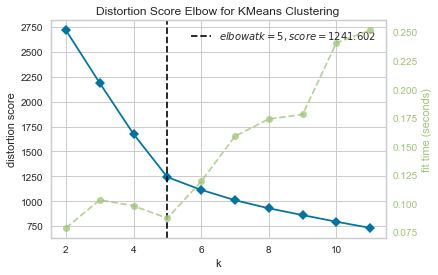

In [33]:
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(normalized_doc_topic_nmf_tfidf_neut)        # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure
elbow_neut = visualizer.elbow_value_

In [34]:
km = KMeans(n_clusters=elbow_neut, random_state=10, init='k-means++')
km.fit_predict(normalized_doc_topic_nmf_tfidf_neut)
neutral_df['cluster'] = km.labels_
neutral_df

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,review_text,movie,review_site,rating,sentiment,review_tokens,review_processed,cluster
245,Not bad but not great. I thought the CGI was ...,lionking,imdb,5,neutral,"[not, bad, not, great, think, cgi, great, time...",not bad not great think cgi great time emotion...,3
282,Copyright Why they didn't yet give credit to ...,lionking,imdb,6,neutral,"[copyright, not, give, credit, kimba, white, l...",copyright not give credit kimba white lion???t...,0
422,The same story + CG + blandness = pointless Y...,lionking,imdb,5,neutral,"[story, cg, blandness, pointless, yes, cg, fil...",story cg blandness pointless yes cg film pheno...,3
423,Disappointed It was disappointed to watch it ...,lionking,imdb,5,neutral,"[disappointed, disappoint, watch, with, nothin...",disappointed disappoint watch with nothing new...,2
427,"no point Visually it's amazing, for the first...",lionking,imdb,5,neutral,"[no, point, visually, amaze, ﻿1, 10, minute, s...",no point visually amaze ﻿1 10 minute story son...,2
...,...,...,...,...,...,...,...,...
3018,With unlimited card - Sai and Akeela,cinderella,rottentomatoes,3,neutral,"[with, unlimited, card, sai, akeela]",with unlimited card sai akeela,2
3019,An alright movie. Though if you're looking for...,cinderella,rottentomatoes,3,neutral,"[alright, movie, look, fresh, not]",alright movie look fresh not,3
3022,good but not as good as malificent.,cinderella,rottentomatoes,3,neutral,"[good, not, good, malificent]",good not good malificent,0
3027,"A delightful, beautiful take on the classic fa...",cinderella,rottentomatoes,3,neutral,"[delightful, beautiful, classic, fairytale, ge...",delightful beautiful classic fairytale genuine...,3


In [35]:
neutral_df['cluster'].value_counts()

2    1761
1    1423
3    1376
4    1229
0    1126
Name: cluster, dtype: int64

In [36]:
tfidfvec = TfidfVectorizer(ngram_range=(1,5), min_df=0.05, stop_words=['movie','film'])
doc_word_tfidfvec_neutral = tfidfvec.fit_transform(neutral_corpus)
print(doc_word_tfidfvec_neutral.shape)
tfidfvec.get_feature_names()
NMF_dimreduc = NMF(n_components=3,random_state=10)
tfidfvec_NMF_neutral = NMF_dimreduc.fit_transform(doc_word_tfidfvec_neutral) 
print(tfidfvec_NMF_neutral.shape)
display_topics(NMF_dimreduc, tfidfvec.get_feature_names(), 15)

(6915, 90)
(6915, 3)

Topic  0
not, with, like, disney, feel, great, make, story, character, version, animate, song, live, voice, little

Topic  1
good, not, pretty, smith, think, great, overall, genie, cartoon, job, music, fun, kid, bad, act

Topic  2
original, well, remake, okay, not, like, change, song, nothing, scene, lack, amaze, music, enjoy, new


In [37]:
#cluster then cosine similarity [find cluster that it's closest to, for that one document]

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

ModuleNotFoundError: No module named 'wordcloud'